In [720]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities, matutils
import nltk
import re
from pprint import pprint
from textblob import TextBlob
import matplotlib
from nltk.corpus import stopwords
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.utils.extmath import randomized_svd
import csv
import seaborn as sns
%matplotlib inline

#### Time data for tweets

In [148]:
df_time = pd.read_pickle('tweet_time.pkl')

In [149]:
df_time = pd.concat([no_url_series, df_time.created_at], axis = 1, join = 'inner')

In [150]:
df_time.drop_duplicates(subset = 'text', inplace = True)

In [151]:
def change_time(time_item):
    return datetime.datetime.strptime(time_item,'%a %b %d %H:%M:%S +0000 %Y')

In [154]:
df_time.created_at = df_time.created_at.apply(change_time)

In [292]:
df_time.reset_index(drop = True, inplace = True)

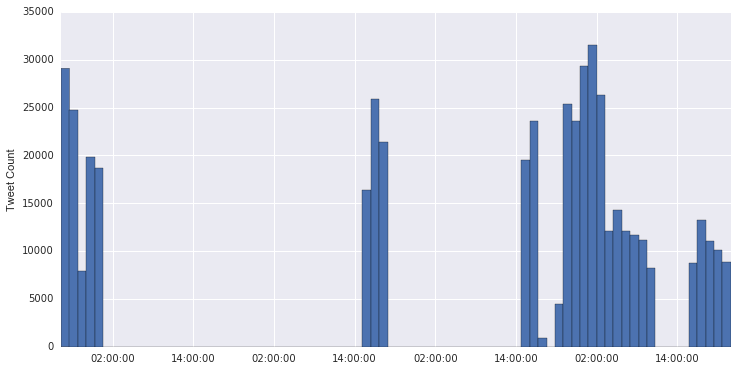

In [733]:
plt.figure(figsize = (12,6))
df_time.created_at.hist(bins=80)
plt.ylabel("Tweet Count");

In [2]:
df = pd.read_pickle('tweet_text.pkl')

#### Convert any url in the tweets to the word 'url' so it can be disregarded as part of the stop words

In [3]:
def convert_url(text):
    replace_urls = re.compile(r"http\S+")
    return re.sub(replace_urls, 'url', text)

In [4]:
no_url_series = df.text.apply(convert_url)

#### Only look at unique tweets. This might exempt legitimate tweets that happen to be the same. Could write custom function to remove only RTs that are identical

In [5]:
unique_tweets = no_url_series.unique()

#### Using a pre-built tokenizer from the nltk package

In [10]:
tweet_token = nltk.tokenize.casual.TweetTokenizer(preserve_case = False)

In [11]:
def tokenized_string(text):
    tokens = nltk.tokenize.casual.TweetTokenizer(preserve_case = False).tokenize(text)
    return ' '.join(tokens)

In [12]:
token_tweets = list(map(tokenized_string, unique_tweets))

In [131]:
def replace_emojis(text):
    no_emoji = text.replace("😂", "(':").replace("😍", "love").replace("😫", "):").replace("💕", "love").replace(
        "👏","cheers").replace("❤", "love").replace("😭", ")':").replace("😢", ")':").replace("😔", "):")
    return no_emoji

In [132]:
token_no_emoji_tweets = list(map(replace_emojis, token_tweets))

#### Our tokenizer is going to split apart punctuation (in an effort to classify emojis), so it is important to re-include punctuation as part of the stop words. Also exempting the search tags and 'rt' for 'retweet'.

In [445]:
stops = stopwords.words('english') + ['olympics', '2016', 'rt', 'rio', 'rio2016', 'rio',
                                      '#rio2016', "#olympics", '#RioOlympics2016', '.', ',', ':', ')', '(', '/',
                                     '&', '=', '?', "\'", '!', '-', '\"', '...', "i'm", "it's", "<", ">", "|", 'url',
                                     "here's"]

####  Perform tfidf on words and bi-grams with a min_df of two. The token pattern works because we have already put a single space between all tokens.

In [446]:
vectorizer = TfidfVectorizer(stop_words = stops, ngram_range=(1,2), min_df=2, token_pattern = r'\S+')
tfidf = vectorizer.fit_transform(token_no_emoji_tweets)

####  Use a truncated SVD to get topics

In [447]:
lsa = TruncatedSVD(100, algorithm = 'randomized')
dtm_lsa_unique = lsa.fit_transform(tfidf)
dtm_lsa_unique = Normalizer(copy=False).fit_transform(dtm_lsa_unique)


####  Scree Plot and Explained Variance Ratio show an elbow after around 15 dimensions

In [701]:
U, Sigma, VT = randomized_svd(tfidf, n_components=100,
                                      n_iter=5)

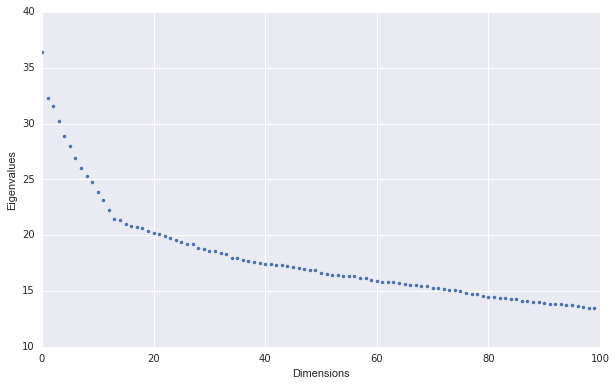

In [729]:
plt.figure(figsize = (10,6))
plt.plot(Sigma, '.')
plt.ylabel('Eigenvalues')
plt.xlabel('Dimensions');

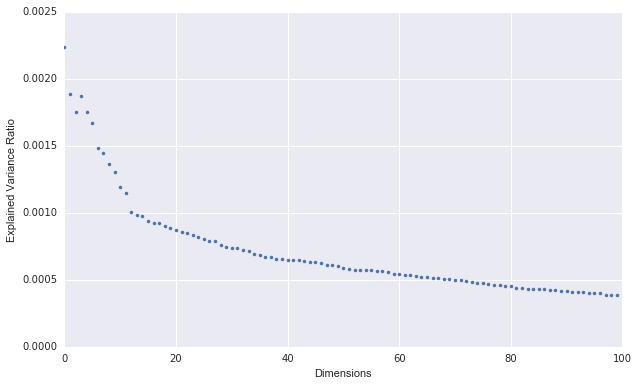

In [728]:
plt.figure(figsize = (10,6))
plt.plot(range(len(lsa.explained_variance_ratio_)), lsa.explained_variance_ratio_, '.')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Dimensions');


#### Let's take a look at few tweets from a topic of our choosing

In [727]:
topic_num = 25
display_amount = 10
pprint(np.array(token_no_emoji_tweets)[np.argsort(dtm_lsa_unique[:,topic_num])[-display_amount:]])

array([ 'rt @handshakevanc : lochte allegedly made up robbery to cover up gas station fight . #nohonour #notruth #nohonesty url',
       'url watch : ryan lochte gets no sympathetic ear from al roker . . . #olympics #rio2016 #ryanlochte',
       'rt @dailymail : ryan lochte refuses to admit he made up #rio2016 robbery url url',
       'rt @sportsbarker : url watch : ryan lochte gets no sympathetic ear from al roker . . . #olympics #rio2016 #ryanlochte',
       'watch : ryan lochte rio gas station video url url',
       'rt @bustedcoverage : watch the ryan lochte rio gas station video url url',
       'watch the ryan lochte gas station security footage : url #rio2016 url',
       'rt @usweekly : watch the ryan lochte gas station security footage : url #rio2016 url',
       "isn't every sponsor a proud sponsor of the olympics ? who are the ashamed sponsors ? besides those who signed ryan lochte , i mean .",
       "i'm just a proud american in the fact that ryan lochte actually knew what

In [452]:
topic_df = pd.DataFrame(lsa.components_,columns = vectorizer.get_feature_names())

####  What are some the most common words associated with the topics?

In [726]:
topic_num = 0
display_amount = 10
topic_df.iloc[topic_num,:].sort_values(ascending = False)[:display_amount]


closing             0.520883
ceremony            0.506189
closing ceremony    0.495127
#closingceremony    0.098818
love                0.091366
watching            0.086401
tokyo               0.085429
mario               0.080807
olympic             0.073642
watch               0.071374
Name: 0, dtype: float64

#### Another method of investigating the data is to see which topics most prominently features a particular keyword

In [700]:
topic_df.loc[:,'basketball'].sort_values(ascending = False)[:10]

73    0.105795
72    0.093060
66    0.090191
43    0.083099
84    0.081610
90    0.076310
95    0.075939
91    0.058858
79    0.053934
44    0.050140
Name: basketball, dtype: float64

#### Get the polarity values

In [41]:
sid = SentimentIntensityAnalyzer()

In [85]:
sid.polarity_scores(":'(")

{'compound': -0.4939, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [704]:
# This function creates a dictionary for each topic of the most prevalant keywords and the overall sentiment
def sentiment_a(topic_df = topic_df, dtm_lsa = dtm_lsa_unique, tweets = token_no_emoji_tweets):
    output = []
    for topic in range(26):
        # Get key words for each topic
        top_topics = topic_df.iloc[topic,:].sort_values(ascending = False)[:10]
        topic_names = top_topics.index.tolist()
        topic_list = [topic_names[0].replace("(':", "😂").replace(")':", "😢")]
        for i in range(1,len(top_topics)):
            if top_topics[i] >= 0.5*top_topics[0] and len(topic_list) < 3:
                topic_to_add = topic_names[i].replace("(':", "😂").replace(")':", "😢")
                check = 'k'
                for word in topic_to_add.split():
                    if word in topic_list[0]:
                        check = None
                if check:
                    topic_list.append(topic_to_add)
            else:
                break
        # Get sentiment of top tweets in that topic
        sia = SentimentIntensityAnalyzer()
        indexes = np.argsort(dtm_lsa[:,topic])[-300:]
        tweet_array = np.array(tweets)[indexes]
        neg = []
        pos = []
        neut = []
        for tweet in tweet_array:
            sent_scores = sia.polarity_scores(tweet)
            neg.append(sent_scores['neg'])
            pos.append(sent_scores['pos'])
            neut.append(sent_scores['neu'])
        cum_sent = sum(neut)+sum(pos)+sum(neg)
        output.append({"Rank": topic, "Key Words in Topic": topic_list, "Positive": round(100*sum(pos)/cum_sent, 1), 
                       "Negative": round(100*sum(neg)/cum_sent, 1), "Neutral": round(100*sum(neut)/cum_sent, 1)})
    return output

In [705]:
totals = sentiment_a()

In [706]:
totals[0]

{'Key Words in Topic': ['closing', 'ceremony'],
 'Negative': 4.1,
 'Neutral': 88.1,
 'Positive': 7.8,
 'Rank': 0}

#### Create time intervals based on a given time step. Used for tracking topics over time

In [303]:
# Inputs are start time, end time, time range
time_array = df_time.created_at

In [349]:
def get_start_stop_idx(start, stop, time_array = time_array, step = 10):
    for i, time in enumerate(time_array):
        if start < time:
            if start_idx == None:
                start_idx = i
            if stop < time:
                stop_idx = i -1
                break
    return start_idx, stop_idx


In [415]:
def get_buckets(start, stop, time_array = time_array, step = 10):
    start_idxs = []
    stop_idxs = []
    start_times = []
    for i, time in enumerate(time_array):
        if start < time:
            start_idxs.append(i)
            start_times.append(start)
            start += datetime.timedelta(minutes = step)
            if stop < time:
                stop_idxs.append(i-1)
                break
            if len(start_idxs) > 1:
                stop_idxs.append(i-1)
    return list(zip(start_idxs, stop_idxs)), start_times[:-1]

In [416]:
time_buckets, start_times = get_buckets(datetime.datetime(2016, 8, 21, 20, 50), datetime.datetime(2016, 8, 22, 11), 
                                     time_array)

In [627]:
topic_avgs = np.array([np.mean(dtm_lsa_unique[time_buckets[0][0]:time_buckets[0][1],col]) for col in range(26)])
for i, bucket in enumerate(time_buckets):
    if i > 0:
        topic_avgs = np.vstack((topic_avgs,
                             np.array([np.mean(dtm_lsa_unique[bucket[0]:bucket[1],col]) for col in range(26)])))

/Users/bholligan/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


####  Remove nan rows

In [680]:
del_rows = [i for i, row in enumerate(topic_avgs) if np.isnan(row[0])]
topic_avgs = np.delete(topic_avgs, del_rows, 0)
ct = 0
for row in del_rows:    
    start_times.pop(row - ct)
    ct =+ 1

In [621]:
for i, item in enumerate(totals):
    print(i, item["Key Words in Topic"])

0 ['closing', 'ceremony']
1 ['latest', 'thanks', 'daily']
2 ['latest', 'thanks', 'daily']
3 ['😂']
4 ['😢']
5 ['love']
6 ['love', 'usa', 'team usa']
7 ['tokyo', '2020', '#closingceremony']
8 ['🇸', '🇺']
9 ['well', 'done']
10 ['#closingceremony', 'sad']
11 ['sad']
12 ['#closingceremony', 'medal', 'sad']
13 ['cheers', '🇧', 'great']
14 ["can't", 'medal', 'count']
15 ["can't", 'wait', 'gold']
16 ['watching']
17 ['@olympics', '@louis_tomlinson']
18 ['watch', 'cheers']
19 ['watching', 'mario']
20 ['🇧', '🇬', 'watch']
21 ['watch', 'great']
22 ['go', 'great']
23 ['go', 'team']
24 ['proud']
25 ['proud', 'lochte', 'ryan']


Interesting Comparisons
- Laughing emoji vs. crying emoji [3 - 4]
- 'Love' vs. 'Sad' [5 - 11]
- 'Cheers' vs 'USA' [13 - 8]
- 'Closing Ceremony' vs News Outlets [0 - 1]
- 'Louis Tomlinson' Showing up early in the broadcast [17]
- 'Tokyo' Announcement [7]
- 'Well Done' is much more british [9]


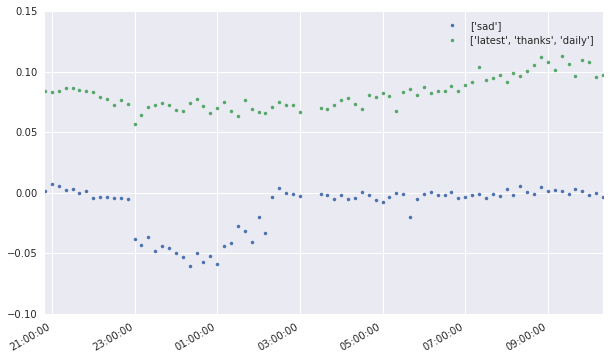

In [724]:
p1 = 11
p2 = 1
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(start_times, topic_avgs[:,p1], '.', label = totals[p1]["Key Words in Topic"])
ax.plot(start_times, topic_avgs[:,p2], '.', label = totals[p2]["Key Words in Topic"])
fig.autofmt_xdate()
plt.legend()


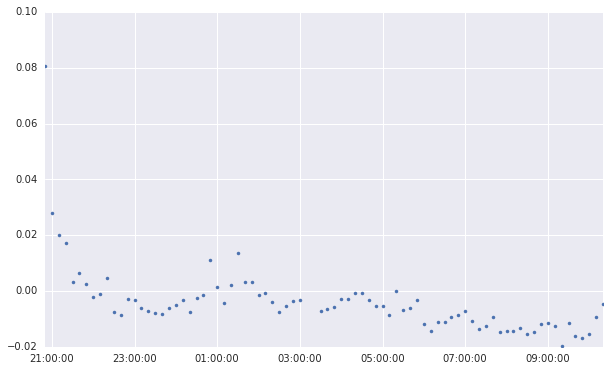

In [725]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(start_times, topic_avgs[:,17], '.')

In [ ]:
# Create a csv for d3. Column names on the header row. 
# Topics to use - 0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 17
# Time, Topic_Names, Pos Polarity, Neg Polarity, Neut Polarity
# Start_times, topic_avgs, totals['key'], totals['pos'], totals['neg']

# start_times is good
# extand everything else except topic_avgs and zip them together

In [718]:
#CSV writer prep
zip_list = []
size = len(start_times)
for t in [0, 1, 3, 4, 5, 7, 8, 9, 11, 13, 17, 25]:
    zip_list.append(zip(start_times, topic_avgs[:,t], [", ".join(totals[t]["Key Words in Topic"])]*size, 
                        [round(totals[t]['Positive'] - totals[t]['Negative'],1)]*size))

In [719]:
headers = ['Time', 'Topic_Relevance', 'Topic_Keywords', 'Polarity_Diff']

with open('data_d3.csv', 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    for topic in zip_list:
        for row_times in topic:
            writer.writerow(row_times)
    